In [1]:
import torch

from model import Model
from config import config
from PIL import Image
from matplotlib import pyplot as plt
from torchvision import transforms
import numpy as np

from typing import Tuple, List

In [2]:
CHECKPOINT_PATH = './runs/model_legendary-blaze-5_047_955.pth'
IMAGE_PATH = './example/image.png'

In [ ]:
model = Model()

model.load_state_dict(torch.load(CHECKPOINT_PATH))

model.eval()

/tmp/ipykernel_140198/3686437757.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(CHECKPOINT_PATH))


<All keys matched successfully>

In [11]:
crop_transform = transforms.Compose([
    transforms.Resize((256, 256)),
])

def crop_image(image: torch.Tensor, size: Tuple[int, int] = (256, 256)) -> List[torch.Tensor]:
    print(image.shape)
    h, w = image.shape[-2:]
    th, tw = size

    if h % th != 0:
        h = h + th - h % th

    if w % tw != 0:
        w = w + tw - w % tw

    image = torch.nn.functional.pad(image, (0, w - image.shape[-1], 0, h - image.shape[-2]), value=-1)

    print(image.shape, w, h)

    i = 0
    j = 0
    cropped_images = []
    while i + th <= h:
        while j + tw <= w:
            print(i, j, i+th, j+tw)
            cropped_images.append(crop_transform(image[..., i:i+th, j:j+tw]))
            j += tw
        j = 0
        i += th
    return cropped_images, (w // tw, h // th)

torch.Size([3, 768, 1024])


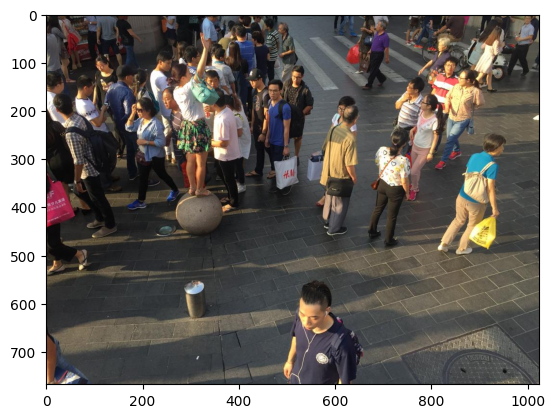

In [13]:
transform = config.transform()
inverse_transform = config.inverse_transform()

img = Image.open(IMAGE_PATH)

img = transform(img)

print(img.shape)

plt.imshow(inverse_transform(img).permute(1, 2, 0))

torch.Size([3, 768, 1024])
torch.Size([3, 768, 1024]) 1024 768
0 0 256 256
0 256 256 512
0 512 256 768
0 768 256 1024
256 0 512 256
256 256 512 512
256 512 512 768
256 768 512 1024
512 0 768 256
512 256 768 512
512 512 768 768
512 768 768 1024
12


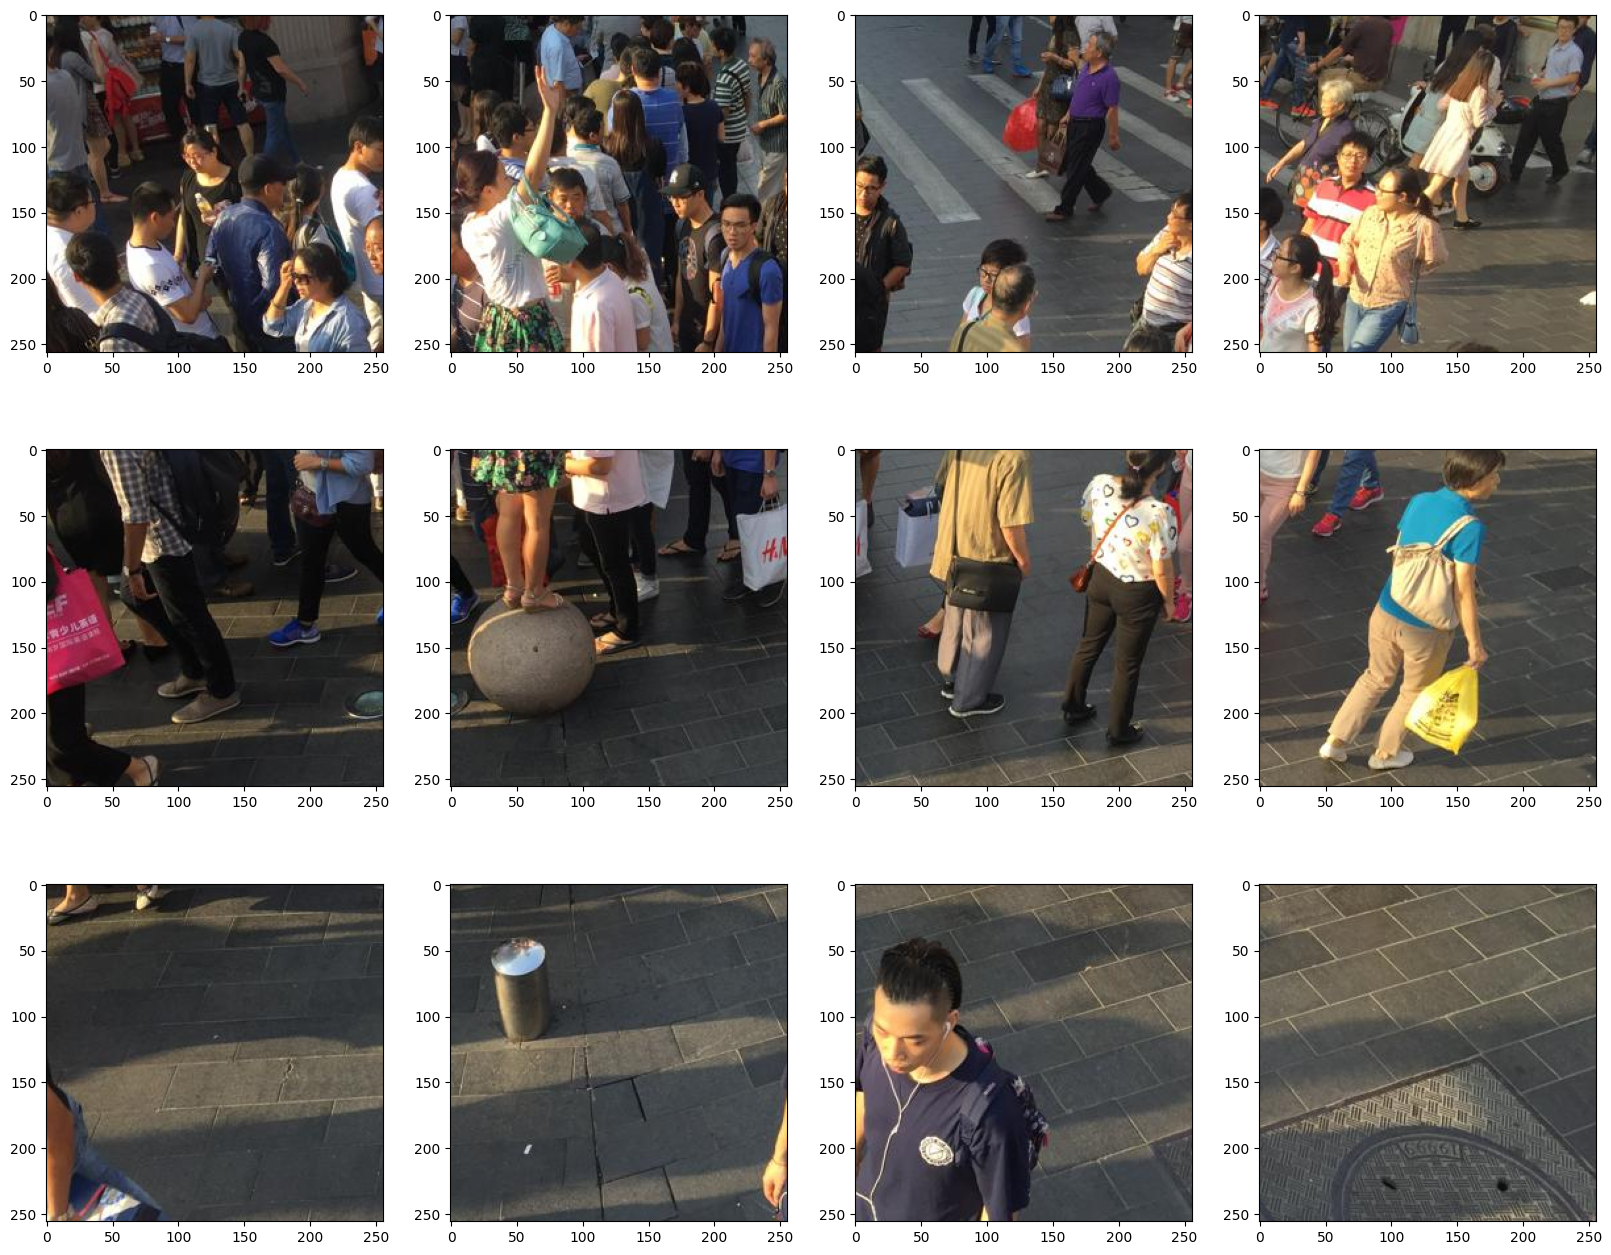

In [18]:
cropped_images, cropped_wh = crop_image(img, size=(256, 256))

# 展示裁剪后的图片

fig, axs = plt.subplots(cropped_wh[1], cropped_wh[0], figsize=(20, 16))
axs = axs.flatten()

print(len(cropped_images))

for i, cropped_image in enumerate(cropped_images):
    axs[i].imshow(inverse_transform(cropped_image).permute(1, 2, 0))

plt.show()

In [23]:
cropped_images, cropped_wh = crop_image(img, size=(256, 256))

for cropped_img in cropped_images:
    print(cropped_img.shape, cropped_img.unsqueeze(0).shape)
    with torch.no_grad():
        output = model(cropped_img.unsqueeze(0))

    print(output.shape)

torch.Size([3, 768, 1024])
torch.Size([3, 768, 1024]) 1024 768
0 0 256 256
0 256 256 512
0 512 256 768
0 768 256 1024
256 0 512 256
256 256 512 512
256 512 512 768
256 768 512 1024
512 0 768 256
512 256 768 512
512 512 768 768
512 768 768 1024
torch.Size([3, 256, 256]) torch.Size([1, 3, 256, 256])


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 640])